# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

S:\Python3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.special import expit

In [3]:
plt.style.use(["dark_background"])
font = {"family": "sans-serif", "sans-serif": ["Tahoma"], "size": 14}
plt.rcParams["figure.figsize"] = [25.0, 8.0]

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"

    def __init__(
        self,
        eta=0.001,
        max_iter=1000,
        C=1.0,
        tol=1e-5,
        random_state=42,
        zero_init=False,
    ):
        """Logistic Regression classifier.

        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init

    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1.0 / (1 + np.exp(-np.dot(X, weights)))
        # faster?
        # return 0.5 * (np.tanh(0.5 * np.dot(X, weights)) + 1)

    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        loss = 0
        for i in range(x.shape[0]):
            M = y[i] * x[i, :].dot(weights)
            loss += np.log(1 + np.exp(-M))
        loss /= x.shape[0]
        loss += np.linalg.norm(weights) ** 2 / (2.0 * self.C)
        return loss

    def fit(self, X, y):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.
        """
        # print("fit X.shape, y.shape", X.shape, y.shape)
        # a constant feature is included to handle intercept
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        # print("fit X_ext.shape", X_ext.shape)
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features)
        else:
            # random weight initialization
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(
                low=-weight_threshold, high=weight_threshold, size=num_features
            )
        # print("self.weights_.shape", self.weights_.shape)
        # print("np.dot(X_ext, self.weights_)", np.dot(X_ext, self.weights_).shape)
        # (1437, 65) . (65, 1) -> (1437, 1)
        delta_history = np.array([])
        self.loss_history = np.array([])
        for _ in range(self.max_iter):
            delta = 0
            for i in range(X_ext.shape[0]):
                M = y[i] * X_ext[i, :].dot(self.weights_)
                delta += y[i] * X_ext[i, :] * (1 - 1.0 / (1 + np.exp(-M)))
            delta /= X_ext.shape[0]
            delta -= self.weights_ / self.C
            delta *= self.eta
            if delta_history.shape[0] == 0:
                delta_history = delta.reshape(1, -1)
            else:
                delta_history = np.concatenate((delta_history, delta.reshape(1, -1)), axis=0)
            # if delta_history.shape[0] > 1:
            #     # delta of delta
            #     dd = np.abs(np.abs(delta_history[-1:].sum()) - np.abs(delta_history[-2:-1].sum()))
            #     print(np.abs(delta.sum()).round(4), dd.round(4), np.linalg.norm(delta).round(4))
            self.weights_ += delta
            self.loss_history = np.append(
                self.loss_history, self.get_loss(X_ext, self.weights_, y)
            )
            if np.linalg.norm(delta) < self.tol:
                break
        # print("delta_history.shape", delta_history.shape)
        # print("loss_history.shape", self.loss_history.shape)
        # print("loss_history", loss_history)

    def predict_proba(self, X):
        """Predict positive class probabilities.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, "weights_"):
            return self.get_sigmoid(X_ext, self.weights_)
        else:
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")

    def predict(self, X):
        """Predict classes.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        y_pred = self.predict_proba(X)
        return np.where(y_pred >= 0.5, 1, -1)


In [6]:
from sklearn import datasets
from sklearn import metrics

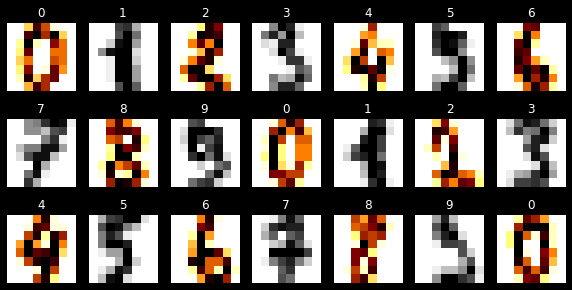

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
# -1 = 0,2,4,...
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1;

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
answ = np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05])

In [14]:
np.set_printoptions(
    precision=6,
    suppress=True,
    linewidth=100,
    threshold=1000,
    formatter=dict(float_kind=lambda x: "%.8f" % x),
)
answ[:21]
lr_clf.weights_[:21]

array([0.00000310, 0.00000000, 0.00004180, 0.00054770, 0.00022130, 0.00048750, 0.00135770,
       0.00059780, 0.00005640, -0.00000070, 0.00016910, 0.00025190, -0.00043700, 0.00036190,
       0.00100490, 0.00042280, 0.00002570, 0.00000030, -0.00001150, -0.00072440, -0.00026200])

array([0.00000313, 0.00000000, 0.00004175, 0.00054767, 0.00022129, 0.00048747, 0.00135769,
       0.00059777, 0.00005637, -0.00000070, 0.00016910, 0.00025191, -0.00043702, 0.00036186,
       0.00100487, 0.00042276, 0.00002575, 0.00000035, -0.00001148, -0.00072443, -0.00026200])

In [15]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [16]:
model = CustomLogisticRegression()

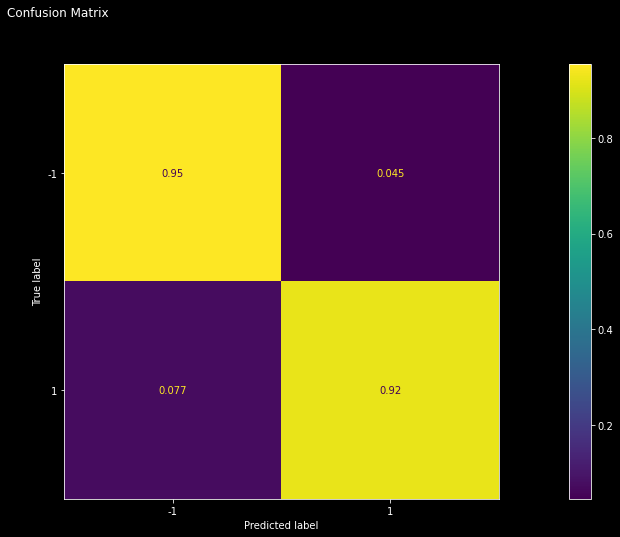

In [17]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [18]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [19]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

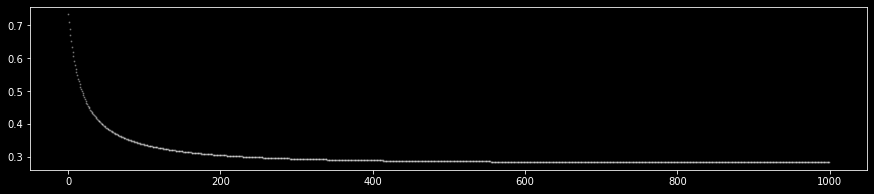

In [20]:
## your code
fig, ax = plt.subplots(figsize=(15, 3))
x_axis = np.arange(model.loss_history.shape[0])
params = {"s": 1, "alpha": 0.3}
_ = ax.scatter(x_axis, model.loss_history, marker="o", c="w", **params)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

lr: 0.001 
        train_acc: 0.8983994432846207 
         test_acc: 0.9111111111111111
lr: 0.005 
        train_acc: 0.9130132219902575 
         test_acc: 0.9416666666666667
lr: 0.01 
        train_acc: 0.825330549756437 
         test_acc: 0.8194444444444444
lr: 0.015 
        train_acc: 0.8232428670842032 
         test_acc: 0.8111111111111111
lr: 0.02 
        train_acc: 0.5741127348643006 
         test_acc: 0.5611111111111111
lr: 0.03 
        train_acc: 0.615866388308977 
         test_acc: 0.5722222222222222


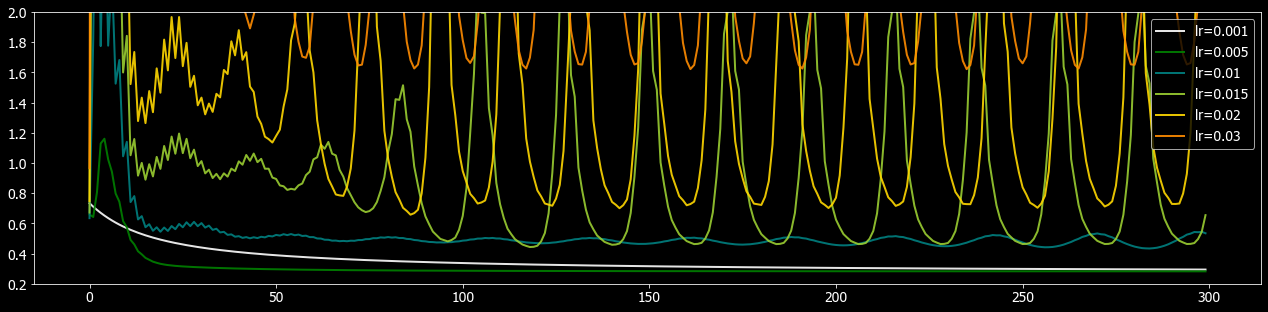

In [21]:
## your code
import matplotlib
font = {"family": "sans-serif", "sans-serif": ["Tahoma"], "size": 14}
matplotlib.rc("font", **font)
params = {"C": 1.0, "tol": 1e-5, "max_iter": 300}
_, ax = plt.subplots(figsize=(22, 5))
plt_params = {"alpha": 0.9, "lw": 2}
ax.set_prop_cycle(color=["w", "g", "teal", "yellowgreen", "gold", "darkorange", "r"])
for lr in [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]:
    clf = CustomLogisticRegression(eta=lr, **params)
    clf.fit(X_train, y_train)
    print(
        f"""lr: {lr} 
        train_acc: { metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train)} 
         test_acc: { metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test) }"""
    )
    x_axis = np.arange(clf.loss_history.shape[0])
    _ = ax.plot(x_axis, clf.loss_history, label=f"lr={lr}", **plt_params)
_ = ax.set_ylim(ymin=0.2, ymax=2.0)
_ = ax.legend(loc="best")

< your thoughts ><br/>
lr=0.001 - плавное равномерное снижение, но есть недостаток - медленное. Слишком маленький шаг.<br/>
lr=0.005 - есть скачок в начале, но потом равномерность и скорость, на 20ой итерации приличный отрыв от 0.001. Из проверенных lr это лучший вариант и по test_acc.<br/>
lr=0.01 - Видимо увеличенный шаг приводит к прыганью вокруг оптимального значения и создает синусоиду.<br/>
После lr=0.01 усиливается нестабильность. Не понятно почему происходит нарастание значений функции потерь. Ведь по идее даже со слишким высоким шагом градиента, оптимальное значение должно остаться в локальном минимуме, что по идее происходит в случае lr=0.01. Возможно где-то ошибка в реализации.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

C: 0.1 
        train_acc: 0.7202505219206681 
         test_acc: 0.6722222222222223
C: 0.5 
        train_acc: 0.9046624913013221 
         test_acc: 0.9277777777777778
C: 1.0 
        train_acc: 0.9130132219902575 
         test_acc: 0.9416666666666667
C: 3.0 
        train_acc: 0.9164926931106472 
         test_acc: 0.9416666666666667
C: 10.0 
        train_acc: 0.9164926931106472 
         test_acc: 0.9388888888888889
C: 100.0 
        train_acc: 0.9171885873347251 
         test_acc: 0.9388888888888889


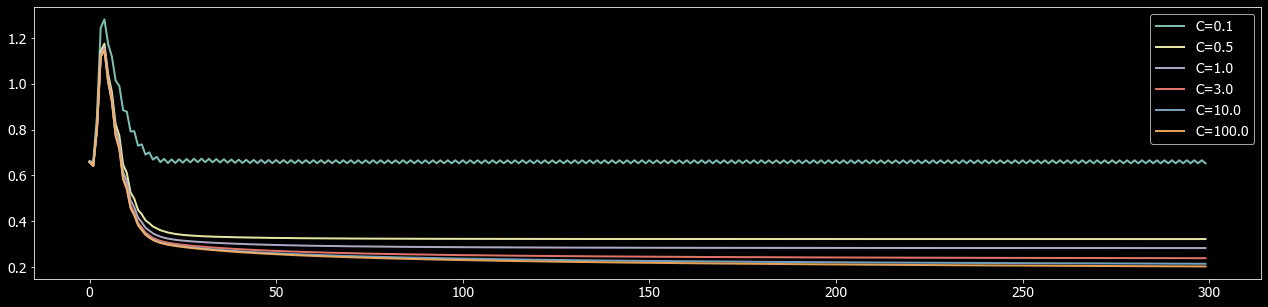

In [22]:
## your code
# lr из предыдущего шага
params = {"eta": 0.005, "tol": 1e-5, "max_iter": 300}
_, ax = plt.subplots(figsize=(22, 5))
for C in [0.1, 0.5, 1.0, 3.0, 10.0, 100.0]:
    clf = CustomLogisticRegression(C=C, **params)
    clf.fit(X_train, y_train)
    print(
        f"""C: {C} 
        train_acc: { metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train)} 
         test_acc: { metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test) }"""
    )
    x_axis = np.arange(clf.loss_history.shape[0])
    _ = ax.plot(x_axis, clf.loss_history, label=f"C={C}", **plt_params)
# _ = ax.set_ylim(ymin=0.1, ymax=0.3)
_ = ax.legend(loc="best")


< your thoughts ><br/>
Видно, что лосс снижается по мере увеличения регуляризации, но происходит оверфит - рост точности на трейне, но падение на тесте. Судя по test_acc С от 1 до 3 выглядит оптимально.

**(0.5 points)** Compare zero initialization and random initialization. 

zero_init: True 
        train_acc: 0.9130132219902575 
         test_acc: 0.9416666666666667
zero_init: False 
        train_acc: 0.9130132219902575 
         test_acc: 0.9416666666666667


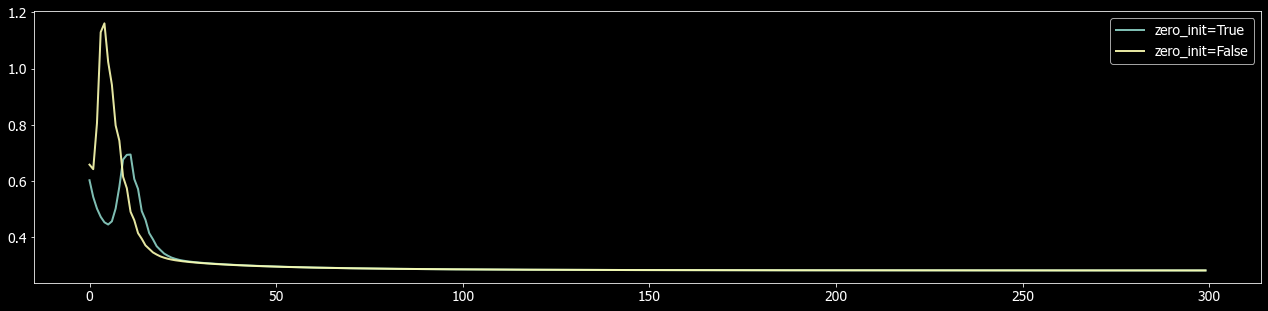

In [23]:
## your code
params = {"eta": 0.005, "tol": 1e-5, "max_iter": 300}
_, ax = plt.subplots(figsize=(22, 5))
for zero_init in [True, False]:
    clf = CustomLogisticRegression(zero_init=zero_init, **params)
    clf.fit(X_train, y_train)
    print(
        f"""zero_init: {zero_init} 
        train_acc: { metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train)} 
         test_acc: { metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test) }"""
    )
    x_axis = np.arange(clf.loss_history.shape[0])
    _ = ax.plot(x_axis, clf.loss_history, label=f"zero_init={zero_init}", **plt_params)
_ = ax.legend(loc="best")

< your thoughts ><br/>
Со случайной инициализацией модель чуть быстрее сходится, но на итоговой точности разницы не видно.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [24]:
from sklearn.metrics.pairwise import euclidean_distances

class CustomKNeighborsClassifier:
    _estimator_type = "classifier"

    def __init__(self, n_neighbors=5, weights="uniform", eps=1e-9):
        """K-Nearest Neighbors classifier.

        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps

    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        return euclidean_distances(X, Y)

    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position
                corresponds to the weight of the i-th class.
        """
        # <your code>
        # print(y.shape, weights.shape)
        assert y.shape == weights.shape
        assert len(self.classes_) == len(np.unique(y))
        n_classes = len(self.classes_)
        res = np.zeros(n_classes)
        for i in range(n_classes):
            res[i] = np.sum(weights[np.where(y == self.classes_[i])])
            # print(weights[np.where(y == classes[i])])
        return res

    def fit(self, X, y):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)

    def predict_proba(self, X):
        """Predict positive class probabilities.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if not hasattr(self, "points"):
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
        # <your code>
        # 360 - n of test samples,  1437 - n of train samples
        # print("self.points", self.points.shape)  # (1437, 64)
        P = self.get_pairwise_distances(X, self.points)  # -> (360, 1437)
        weights_of_points = np.ones(P.shape)
        P_ind = P.argsort(axis=1)
        P_ind = P_ind[:, : self.n_neighbors]  # (360, 1437) - > (360, n_neighbors)
        P.sort(axis=1)
        P = P[:, : self.n_neighbors]  # (360, 1437) - > (360, n_neighbors)
        if self.weights == "distance":
            weights_of_points = 1 / (P  + self.eps)
        # print("X.shape", X.shape)  # (360, 64)

        # from sklearn 0.24.2
        n_classes = len(self.classes_)
        all_rows = np.arange(X.shape[0])
        pred_labels = self.y[P_ind]
        proba = np.zeros((X.shape[0], n_classes))
        for i, idx in enumerate(pred_labels.T):
            # print(i)
            # print(idx)
            # print(pred_labels.T)
            # print(weights_of_points[:, i])
            proba[all_rows, idx] += weights_of_points[:, i]
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer
        return proba

    def predict(self, X):
        """Predict classes.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pp = self.predict_proba(X)
        res = []
        for i in range(pp.shape[0]):
            res.append(np.argmax(pp[i, :]))
        return np.array(res)


In [25]:
import sklearn
sklearn.__version__

'0.24.2'

In [26]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [27]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [28]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

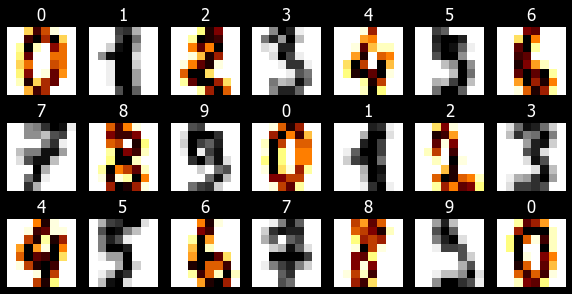

In [29]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    _ = ax.set_axis_off()
    _ = ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    _ = ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [30]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [31]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

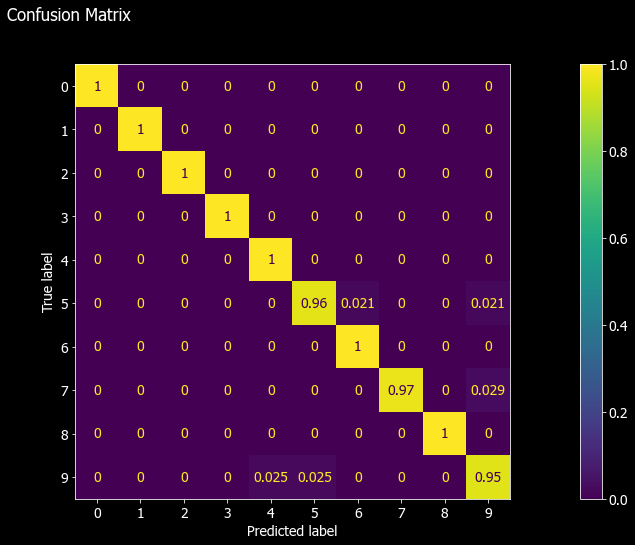

In [32]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [33]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >
Модель иногда принимает 5ку за 6ку или 9ку. А 9ку принимает за 4 и 5.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

<i>"compare the output probabilities"</i><br/>
Непонятная формулировка. Что именно сравнить? Так что я сравнил пару вещей. Первое - как изменяется среднее максимальных предсказаний по самплам и точность. Второе - значения для библиотечной и кастомной версии.<br/><br/>


In [34]:
def evaluate(X_train_pred, X_test_pred, y_train, y_test):
    res1 = metrics.accuracy_score(y_pred=X_train_pred, y_true=y_train)
    res2 = metrics.accuracy_score(y_pred=X_test_pred, y_true=y_test)
    return res1.round(4), res2.round(4)

In [35]:
## your code
for k in [1, 2, 3, 4, 5, 9, 11, 17, 25, 45, 77]:
    model_1 = KNeighborsClassifier(n_neighbors=k)
    model_2 = CustomKNeighborsClassifier(n_neighbors=k)
    _ = model_1.fit(X_train, y_train)
    model_2.fit(X_train, y_train)
    X_test_pred_1 = model_1.predict_proba(X_test)
    X_test_pred_2 = model_2.predict_proba(X_test)
    test_acc = metrics.accuracy_score(y_pred=X_test_pred_1.argmax(axis=1), y_true=y_test)
    # X_train_pred_1.max(axis=1).shape == (1437,)
    # Если поставить большее X в mean().round(X), то ассерт не пройдет.
    # Значит есть разница в реализации с sklearn.
    meanmax_1 = X_test_pred_1.max(axis=1).mean().round(2)
    meanmax_2 = X_test_pred_2.max(axis=1).mean().round(2)
    print("k", k, "meanmax_1", meanmax_1, "meanmax_2", meanmax_2, "test_acc", test_acc.round(4))
    assert meanmax_1 == meanmax_2


k 1 meanmax_1 1.0 meanmax_2 1.0 test_acc 0.9778
k 2 meanmax_1 0.99 meanmax_2 0.99 test_acc 0.9806
k 3 meanmax_1 0.99 meanmax_2 0.99 test_acc 0.9833
k 4 meanmax_1 0.98 meanmax_2 0.98 test_acc 0.9806
k 5 meanmax_1 0.98 meanmax_2 0.98 test_acc 0.9861
k 9 meanmax_1 0.97 meanmax_2 0.97 test_acc 0.9806
k 11 meanmax_1 0.96 meanmax_2 0.96 test_acc 0.9833
k 17 meanmax_1 0.95 meanmax_2 0.95 test_acc 0.9833
k 25 meanmax_1 0.92 meanmax_2 0.92 test_acc 0.9778
k 45 meanmax_1 0.87 meanmax_2 0.87 test_acc 0.9611
k 77 meanmax_1 0.8 meanmax_2 0.8 test_acc 0.9361


Видно, что средний максимум снижается, т.е. все меньше предсказаний в виде одной 1. Это может значить, что при увеличении n_neighbors модель начинает находить самплы все большего количеста классов.
С какого-то момента начинает падать точность на тесте. Почему? Не знаю. Нет времени изучать. Может зависить от размера датасета, количеста и особенностей выбросов, еще чего-нибудь.<br/><br/>Сравнивая результаты библиотечной и кастомной версии я уивидел, что есть различия в том, что выдает predict_proba, которые становятся заметней при увеличении n_neighbors. Значит есть какие-то различия в реализации. Если поменять округление mean().round(2), то ассерт не пройдет. Нет времени изучать подробней. И так много чего надо попробовать.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [36]:
## your code
for k in [3, 5, 10, 20, 40, 80, 150, 300, 500]:
    # model_1 = KNeighborsClassifier(n_neighbors=k, weights='distance')
    # model_2 = KNeighborsClassifier(n_neighbors=k)
    model_1 = CustomKNeighborsClassifier(n_neighbors=k, weights='distance')
    model_2 = CustomKNeighborsClassifier(n_neighbors=k)
    _ = model_1.fit(X_train, y_train)
    _ = model_2.fit(X_train, y_train)
    X_test_pred_1 = model_1.predict(X_test)
    X_test_pred_2 = model_2.predict(X_test)
    test_acc_1 = metrics.accuracy_score(y_pred=X_test_pred_1, y_true=y_test).round(4)
    test_acc_2 = metrics.accuracy_score(y_pred=X_test_pred_2, y_true=y_test).round(4)
    diff = round(test_acc_1 - test_acc_2, 5)
    print("k", k, "test_acc_1", test_acc_1, "test_acc_2", test_acc_2, diff)

k 3 test_acc_1 0.9833 test_acc_2 0.9833 0.0
k 5 test_acc_1 0.9861 test_acc_2 0.9861 0.0
k 10 test_acc_1 0.9806 test_acc_2 0.9833 -0.0027
k 20 test_acc_1 0.9778 test_acc_2 0.9778 0.0
k 40 test_acc_1 0.9722 test_acc_2 0.9667 0.0055
k 80 test_acc_1 0.95 test_acc_2 0.9333 0.0167
k 150 test_acc_1 0.9111 test_acc_2 0.9028 0.0083
k 300 test_acc_1 0.8972 test_acc_2 0.8472 0.05
k 500 test_acc_1 0.875 test_acc_2 0.7194 0.1556


< your thoughts ><br/> Не вижу особой разницы на тесте. Когда разница появляется, то это происходит на неоптимальных значениях n_neighbors. Видимо неподходящие датасет для такого сравнения.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts > Без понятия.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts > Ну можно придумать особый датасет, где например есть явные центры классов и можно было бы вычислять расстрояния самплов до этих центров, а не до соседних самплов. Допустим какая-то симуляция гравитации частиц из физики, где сила воздействия обратно пропорциональна квадрату расстояния.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [37]:
PATH = "./data/"

In [38]:
# data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
train = pd.read_csv(os.path.join(PATH, "titanic", "train.csv"))
test = pd.read_csv(os.path.join(PATH, "titanic", "test.csv"))
submission = pd.read_csv(os.path.join(PATH, "titanic", "sample_submission.csv"))
train.set_index("PassengerId", verify_integrity=True, inplace=True)
test.set_index("PassengerId", verify_integrity=True, inplace=True)
submission.set_index("PassengerId", verify_integrity=True, inplace=True)

In [39]:
train.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [40]:
## your code
# How many females and males are there in the dataset?
train["is_train"] = 1
test["is_train"] = 0
full_df = pd.concat([train, test], verify_integrity=True)
full_df.Sex.value_counts().to_frame()

,Sex
male,125871
female,74129


In [41]:
# What about the survived passengers? 
train.Survived.value_counts().to_frame()

,Survived
0,57226
1,42774


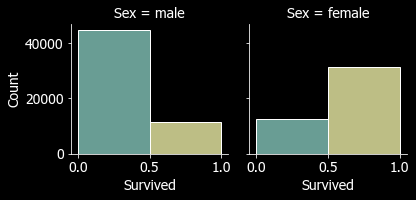

In [42]:
# Is there any relationship between the gender and the survival?
g = sns.FacetGrid(train, col="Sex", hue="Survived")
_ = g.map_dataframe(sns.histplot, x="Survived", binwidth=0.5, binrange=(0, 1))

< your thoughts > Мои мысли, мои скакуны...

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

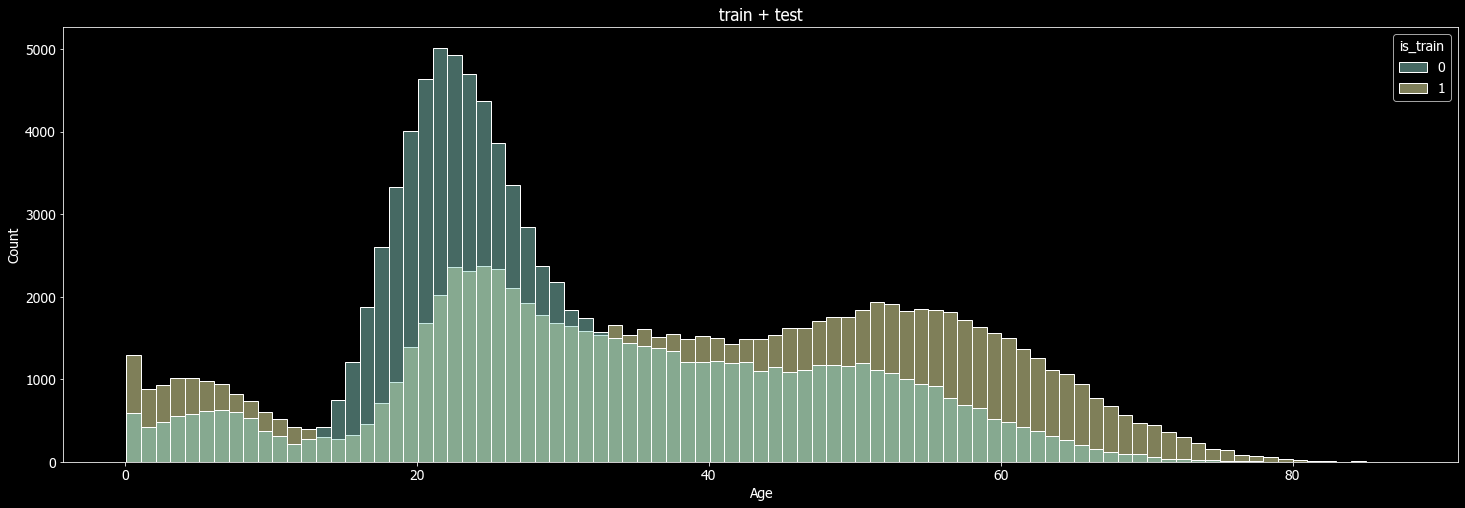

In [43]:
## your code
# Plot age distribution of the passengers. 
bins = 87
_ = sns.histplot(x=full_df["Age"], hue=full_df["is_train"], bins=bins).set(title="train + test")

In [44]:
# What is the average and the median age of survived and deceased passengers?
"mean:", train.groupby("Survived").Age.mean().to_dict()
"median:", train.groupby("Survived").Age.median().to_dict()

('mean:', {0: 36.708694881533724, 1: 40.55379931430776})

('median:', {0: 36.0, 1: 43.0})

In [45]:
pal = ["r", "g"]

def histplt(col, txt_pos, max_grid=None, log_scale=False, hline=None):
    global train, test
    """ sns.histplot with options """
    _, axes = plt.subplots(1, 2)
    sns.histplot(
        x=train[col],
        hue=train["Survived"],
        palette=pal,
        bins=120,
        multiple="stack",
        log_scale=log_scale,
        ax=axes[0],
    ).set(title="train")
    mean = round(train[col].mean(), 1)
    median = round(train[col].median(), 1)
    mode = round(train[col].mode(), 1)
    for mode_val in mode:
        axes[0].axvline(x=mode_val, ls="-.", linewidth=1.5, c="y")
    if max_grid: # grid
        for i in range(1, max_grid, 100): 
            axes[0].axvline(x=i, ls="-", linewidth=0.5, c="g")
    axes[0].axvline(x=mean, ls="--", linewidth=1, c="red")
    axes[0].axvline(x=median, ls="--", linewidth=1, c="w")
    quantile25 = round(train[col].quantile(q=0.25), 1)
    axes[0].axvline(x=quantile25, ls="--", linewidth=0.5, c="w")
    quantile75 = round(train[col].quantile(q=0.75), 1)
    axes[0].axvline(x=quantile75, ls="--", linewidth=0.5, c="w")
    axes[0].annotate(
        f"red line:{mean} (mean)\nwhite: {median} (median)\ngrey: {mode.values}(mode)\nlog scale:{log_scale}",
        txt_pos,
        fontsize=14,
        ha="center",
        va="center",
    )
    sns.histplot(x=test[col], bins=120, log_scale=log_scale, ax=axes[1]).set(title="test")
    mean = round(test[col].mean(), 1)
    median = round(test[col].median(), 1)
    mode = round(train[col].mode(), 1)
    for mode_val in mode:
        axes[1].axvline(x=mode_val, ls="-.", linewidth=1.5, c="y")
    if max_grid:
        for i in range(1, max_grid, 100):
            axes[1].axvline(x=i, ls="-", linewidth=0.5, c="g")
    axes[1].axvline(x=mean, ls="--", linewidth=1, c="red")
    axes[1].axvline(x=median, ls="--", linewidth=1, c="w")
    quantile25 = round(test[col].quantile(q=0.25), 1)
    axes[1].axvline(x=quantile25, ls="--", linewidth=0.5, c="w")
    quantile75 = round(test[col].quantile(q=0.75), 1)
    axes[1].axvline(x=quantile75, ls="--", linewidth=0.5, c="w")
    axes[1].annotate(
        f"red line:{mean}\nwhite: {median}\ngrey: {mode.values}\nlog scale:{log_scale}",
        txt_pos,
        fontsize=14,
        ha="center",
        va="center",
    )
    if hline:
        axes[0].axhline(y=hline, ls="-", linewidth=0.5, c="grey")
        axes[1].axhline(y=hline, ls="-", linewidth=0.5, c="grey")

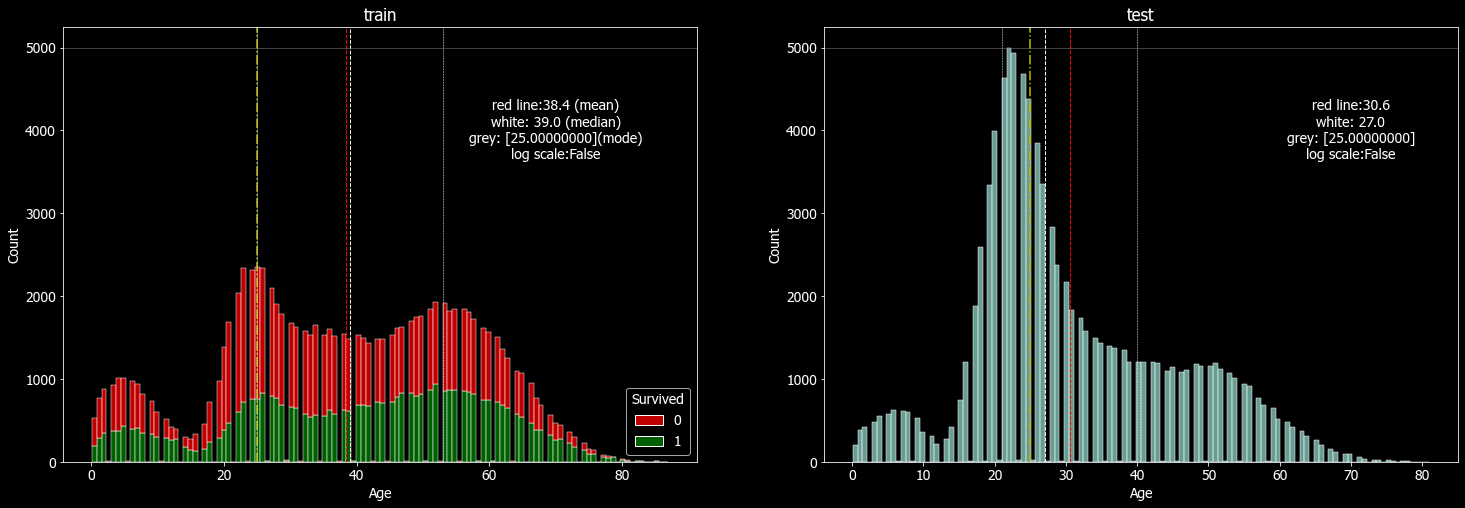

In [46]:
# Do age distributions differ for survived and deceased passengers?
histplt(col='Age', txt_pos=(70, 4000), hline=5000)
# На трейне особой разницы в респределении нет.

In [47]:
# Why?
# Откуда мне знать зачем в искусственном датасете так сделали, что распределения возрастов
# на трейне и тесте заметно отличаются, а распределения выживших ине выживших на трейне
# очень похожи.

< your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

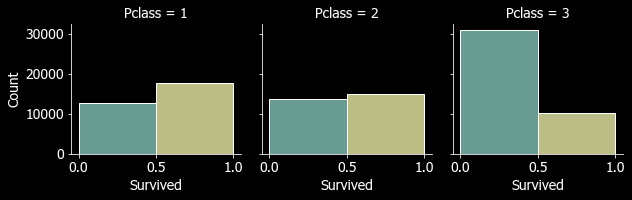

In [48]:
## your code
# Explore "passenger class" and "embarked" features.
g = sns.FacetGrid(train, col="Pclass", hue="Survived")
_ = g.map_dataframe(sns.histplot, x="Survived", binwidth=0.5, binrange=(0, 1))

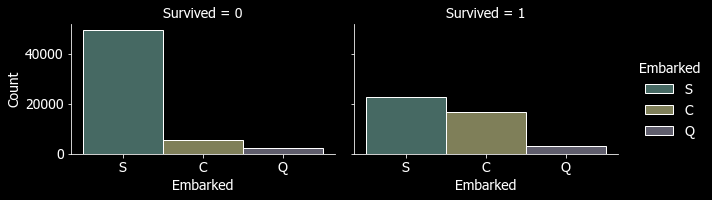

In [49]:
_ = sns.displot(data=train, x="Embarked", col="Survived", hue="Embarked", height=3, aspect=1.5)

In [50]:
# What class was "the safest"?
# Pclass == 1, Embarked == C
train.groupby('Pclass').Survived.mean().to_dict()
train.groupby('Embarked').Survived.mean().to_dict()

{1: 0.5797789873000165, 2: 0.5250183060776178, 3: 0.24730527239916109}

{'C': 0.7512958038491008, 'Q': 0.596976401179941, 'S': 0.3152940850302888}

In [51]:
# Is there any relationship between the embarkation port and the survival?
# Да.

< your thoughts >

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [52]:
## your code
def show_types_and_na(df):
    """Return table with types, nunique, NAs, min, max"""
    d = {}
    for col in df.columns:
        nna = df[col].isna().sum()
        nna_percent = str(round((nna / df.shape[0]) * 100.0, 1)) + "%"
        d[col] = {
            "dtype": df[col].dtype,
            "nunique": df[col].nunique(),
            "na": nna,
            "na_%": nna_percent,
            "min": df[col].min() if df[col].dtype != "object" else "_",
            "max": df[col].max() if df[col].dtype != "object" else "_",
        }
    return pd.DataFrame.from_dict(d)

In [53]:
show_types_and_na(full_df)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train
dtype,float64,int64,object,object,float64,int64,int64,object,float64,object,object,int64
nunique,2,3,174854,2,175,7,8,132613,22649,45442,3,2
na,100000,0,0,0,6779,0,0,9804,267,138697,527,0
na_%,50.0%,0.0%,0.0%,0.0%,3.4%,0.0%,0.0%,4.9%,0.1%,69.3%,0.3%,0.0%
min,0,1,_,_,0.08,0,0,_,0.05,_,_,0
max,1,3,_,_,87,8,9,_,744.66,_,_,1


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts > Можно было бы просто отбросить целые фичи где процент пропущенных самплов слишком большой. А можно просто заполнить пропуски чем-то. Для категориальных можно просто ввести новую категорию "NA". Для вещественных - заполнить средним значением. На таком достаточно большом датасете без понятия какой способ лучше.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [54]:
## your code
cols_both = [x for x in train.columns if x in train.columns and x in test.columns]
col_target = [x for x in train.columns if x in train.columns and x not in test.columns]
full_df["had_na_in_row"] = np.where(full_df[cols_both].isna().any(axis=1) == True, 1, 0)

In [55]:
full_df.groupby(['is_train', 'had_na_in_row']).count()

Survived  Pclass   Name    Sex    Age  SibSp  Parch  \
is_train had_na_in_row                                                        
0        0                     0   27981  27981  27981  27981  27981  27981   
         1                     0   72019  72019  72019  68532  72019  72019   
1        0                 30881   30881  30881  30881  30881  30881  30881   
         1                 69119   69119  69119  69119  65827  69119  69119   

                        Ticket   Fare  Cabin  Embarked  
is_train had_na_in_row                                  
0        0               27981  27981  27981     27981  
         1               66838  71886   1188     71742  
1        0               30881  30881  30881     30881  
         1               64496  68985   1253     68869

In [56]:
full_df["Age_na"] = full_df.Age.isna()
full_df["Age"] = full_df.Age.fillna(full_df.Age.mean())
full_df["Ticket_na"] = full_df.Ticket.isna()
full_df["Ticket"] = full_df.Ticket.fillna("_NA_")
full_df["Fare_na"] = full_df.Fare.isna()
full_df["Fare"] = full_df.Fare.fillna(full_df.Fare.median())
full_df["Cabin_na"] = full_df.Cabin.isna()
full_df["Cabin"] = full_df.Cabin.fillna("_NA_")
full_df["Embarked_na"] = full_df.Embarked.isna()
full_df["Embarked"] = full_df.Embarked.fillna("_NA_")
assert full_df[cols_both].isna().sum().sum() == 0
print(f"NAs were replaced")

NAs were replaced


In [57]:
show_types_and_na(full_df)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train,had_na_in_row,Age_na,Ticket_na,Fare_na,Cabin_na,Embarked_na
dtype,float64,int64,object,object,float64,int64,int64,object,float64,object,object,int64,int32,bool,bool,bool,bool,bool
nunique,2,3,174854,2,176,7,8,132614,22649,45443,4,2,2,2,2,2,2,2
na,100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
na_%,50.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
min,0,1,_,_,0.08,0,0,_,0.05,_,_,0,0,False,False,False,False,False
max,1,3,_,_,87,8,9,_,744.66,_,_,1,1,True,True,True,True,True


In [58]:
full_df = pd.get_dummies(full_df, columns=["Pclass"])
full_df = pd.get_dummies(full_df, columns=["Sex"])
full_df = pd.get_dummies(full_df, columns=["SibSp"])
full_df = pd.get_dummies(full_df, columns=["Parch"])
full_df = pd.get_dummies(full_df, columns=["Embarked"])

In [59]:
X_df = full_df[~full_df.Survived.isna()].copy()
y = X_df.Survived.values.astype("int")
X_df.drop("Survived", axis=1, inplace=True)
X_df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
X = X_df.values
X.shape, y.shape

((100000, 33), (100000,))

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = make_pipeline(StandardScaler(), LogisticRegression())
cross_val_score(pipeline, X_train, y_train, cv=KFold(n_splits=4), scoring="accuracy")
_ = pipeline.fit(X_train, y_train)
metrics.accuracy_score(y_pred=pipeline.predict(X_test), y_true=y_test)


array([0.77091429, 0.77577143, 0.77160000, 0.77222857])

0.7717666666666667

In [62]:
from sklearn.neighbors import KNeighborsClassifier
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=11))
cross_val_score(pipeline, X_train, y_train, cv=KFold(n_splits=2), scoring="accuracy")
_ = pipeline.fit(X_train, y_train)
metrics.accuracy_score(y_pred=pipeline.predict(X_test), y_true=y_test)

array([0.75591429, 0.75768571])

0.7582

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [63]:
## your code
# KNeighborsClassifier слишком долго работает
from sklearn.ensemble import VotingClassifier
p1 = make_pipeline(StandardScaler(), LogisticRegression())
p2 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=11))
vc = VotingClassifier(estimators=[('p1', p1), ('p2', p2)], voting='soft')
cross_val_score(vc, X_train, y_train, scoring='accuracy', cv=2)
_ = vc.fit(X_train, y_train)
metrics.accuracy_score(y_pred=vc.predict(X_test), y_true=y_test)

array([0.77040000, 0.77282857])

0.7717666666666667

In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

In [65]:
def add_features_1(full_df):
    full_df = pd.get_dummies(full_df, columns=["SibSp"])
    full_df = pd.get_dummies(full_df, columns=["Parch"])
    full_df["Ticket"] = full_df["Ticket"].str[0]
    full_df["Ticket"] = full_df.Ticket.fillna("N")
    full_df = pd.get_dummies(full_df, columns=["Ticket"])
    conditions = [
        (full_df["Age"].le(8)),
        (full_df["Age"].gt(8) & full_df["Age"].le(16)),
        (full_df["Age"].gt(16) & full_df["Age"].le(24)),
        (full_df["Age"].gt(24) & full_df["Age"].le(32)),
        (full_df["Age"].gt(32) & full_df["Age"].le(48)),
        (full_df["Age"].gt(48) & full_df["Age"].le(64)),
        (full_df["Age"].gt(64)),
    ]
    choices = [0, 1, 2, 3, 4, 5, 6]
    full_df["Age_n"] = np.select(conditions, choices)
    full_df = pd.get_dummies(full_df, columns=["Age_n"])
    return full_df


In [66]:
# target encoding
# https://www.kaggle.com/code/erikgarcia/tps-april-2021-logistic-regression-4-variables/notebook
def add_features_2(full_df, y):
    full_df["Cabin"] = full_df["Cabin"].str[0]
    full_df["Cabin"] = full_df["Cabin"].fillna("N")
    full_df.loc[full_df["Cabin"] == "T", "Cabin"] = "N"
    full_df.loc[full_df["Cabin"] == "G", "Cabin"] = "F"
    (full_df[: len(train)].join(y)).groupby(["Cabin"]).agg({"Cabin": "count", "Survived": "mean"})
    aux = full_df.groupby(["Pclass", "Sex", "Cabin"])["Embarked"].agg(lambda x: x.value_counts().index[0])
    full_df["MultiIndex"] = pd.MultiIndex.from_frame(full_df[["Pclass", "Sex", "Cabin"]])
    full_df.loc[full_df["Embarked"].isna(), "Embarked"] = full_df.loc[
        full_df["Embarked"].isna(), "MultiIndex"
    ].map(aux)
    full_df.drop(columns=["MultiIndex"], inplace=True)
    for i in ["Embarked", "Pclass", "Sex", "Cabin"]:
        mean = full_df[: len(train)].join(y).groupby(i)["Survived"].mean()
        full_df[i] = full_df[i].map(mean)
    return full_df

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [80]:
full_df = pd.concat([train, test], verify_integrity=True)
full_df.drop("Survived", axis=1, inplace=True)
full_df["Age_na"] = full_df.Age.isna()
full_df["Age"] = full_df.Age.fillna(full_df.Age.mean())
full_df["Fare_na"] = full_df.Fare.isna()
full_df["Fare"] = full_df.Fare.fillna(full_df.Fare.median())
full_df = add_features_1(full_df)
y = train["Survived"]

full_df["Cabin"] = full_df["Cabin"].str[0]
full_df["Cabin"] = full_df["Cabin"].fillna("N")
full_df = pd.get_dummies(full_df, columns=["Cabin"])
full_df["Embarked"] = full_df["Embarked"].fillna("N")
full_df = pd.get_dummies(full_df, columns=["Embarked"])
full_df = pd.get_dummies(full_df, columns=["Pclass"])
full_df = pd.get_dummies(full_df, columns=["Sex"])
# full_df = add_features_2(full_df, y)
assert full_df.isna().sum().sum() == 0
full_df.drop(["Name", "is_train"], axis=1, inplace=True)
X = full_df[:len(train)]
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000))
score = cross_val_score(pipe, X, y, scoring='accuracy', cv=4)
print("cross_val_score:", score.mean())
#
test_df = full_df[len(train):]
assert X.shape == test_df.shape
_ = pipe.fit(X, y)
submission["Survived"] = pipe.predict(test_df)
submission.to_csv("sub.csv")
# получилось меньше 0.79

cross_val_score: 0.77871
